In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import itertools

from scipy.spatial import cKDTree
from scipy         import sparse
from scipy.sparse  import linalg as sparse_linalg
from numba         import njit

# Setup

In [2]:
dimension = 1
npoints   = 50
nfreqs    = 1
nrays     = 1
nboundary = 1

boundary2point = np.array([0])
point2boundary = np.array([npoints for _ in range(npoints)])
point2boundary[0] = 0

rs     = np.array([i for i in range(npoints)])
# rs     = np.logspace(np.log10(10e-5), np.log10(1e+1), npoints, endpoint=True)

xs_blk = np.array([[r,0,0] for r in rs])
xs_bdy = xs_blk[boundary2point]
xs     = xs_blk[:,:dimension]

eta                = np.array([[0.0] for _ in range(npoints  )])
chi                = np.array([[1.0] for _ in range(npoints  )])
operator_condition = eta / chi
boundary_condition = np.array([[10.] for _ in range(nboundary)])
boundary_normal    = np.array([[-1.0, 0.0, 0.0]])

# Setup

In [3]:
import sys
sys.path.append('/home/frederik/Dropbox/GitHub/Magritte/tests/benchmarks/analytic/')
from density_distribution_single_ray import create_model

In [4]:
model = create_model('a')

model.compute_spectral_discretisation()
model.compute_inverse_line_widths    ()
model.compute_LTE_level_populations  ()

model.set_eta_and_chi       ()
model.set_boundary_condition()

0

In [5]:
dimension = model.parameters.dimension()
npoints   = model.parameters.npoints  ()
nfreqs    = model.parameters.nfreqs   ()
nrays     = model.parameters.nrays    ()
nboundary = model.parameters.nboundary()

boundary2point = np.array(model.geometry.boundary.boundary2point)
point2boundary = np.array(model.geometry.boundary.point2boundary)

xs_blk = np.array(model.geometry.points.position)
xs_bdy = xs_blk[boundary2point]
xs     = xs_blk[:,:dimension]
rs     = np.linalg.norm(xs, axis=1)

eta                = np.array(model.eta,                dtype=np.float64)
chi                = np.array(model.chi,                dtype=np.float64)
boundary_condition = np.array(model.boundary_condition, dtype=np.float64)
operator_condition = eta / chi
# boundary_normal    = np.array([[-1.0, 0.0, 0.0]])

# Work

In [6]:
ncp = npoints #64

dis_blk, red_blk = cKDTree(xs_blk).query(xs_blk, ncp)
dis_bdy, red_bdy = cKDTree(xs_bdy).query(xs_bdy, ncp)

dis_bdy = dis_bdy[:,:nboundary]
red_bdy = red_bdy[:,:nboundary]

dis_blk = dis_blk[:,:npoints]
red_blk = red_blk[:,:npoints]

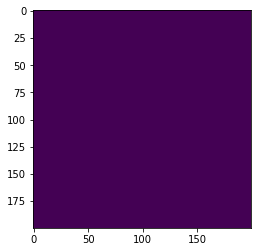

In [7]:
mat = np.zeros((npoints, npoints))
for i, ids in enumerate(red_blk):
    for j in ids:
        mat[i,j] = 1.0
plt.imshow(mat)

In [8]:
red_blk

array([[  0,   1,   2, ..., 197, 198, 199],
       [  1,   0,   2, ..., 197, 198, 199],
       [  2,   1,   3, ..., 197, 198, 199],
       ...,
       [197, 196, 198, ...,   2,   1,   0],
       [198, 197, 199, ...,   2,   1,   0],
       [199, 198, 197, ...,   2,   1,   0]])

In [9]:
@njit
def get_neighbors(i):
    if   (i == 0):
        return [1]
    elif (i == npoints-1):
        return [npoints-2]
    else:
        return [i-1, i+1]

In [10]:
def get_hs_stats():
    """
    Returns for each point the distance to its farthest neighbour,
    and the average distance to all its neighbours.
    """
    # Initialize a new array
    hs_min  = np.zeros(npoints)
    hs_mean = np.zeros(npoints)
    # Loop over all points
    for i in range(npoints):
        # Get distances to neighbours.
        dist = np.linalg.norm(xs[i] - xs[get_neighbors(i)], axis=1)
        hs_min [i] = np.max (dist)
        hs_mean[i] = np.mean(dist)
    return hs_min, hs_mean

In [11]:
hs_min, hs_mean = get_hs_stats()

Computing the gradient based on nearest neighbor information based on Meyer, Eriksson, and Maggio (2001).
For a point at position $\textbf{x}_{i}$, and nearest neighbors $\textbf{x}_{j}$, we can observe that
\begin{equation}
f_{j} - f_{i} \ = \ \left(\textbf{x}_{j} - \textbf{x}_{i} \right) \cdot \nabla f_{i}
\end{equation}

\begin{equation}
\Delta f \ = \ \Delta \textbf{x} \cdot \nabla f
\end{equation}

\begin{equation}
\nabla f \ = \
\left( \Delta \textbf{x} ^{\text{T}} \Delta \textbf{x} \right)^{-1} \ \Delta \textbf{x}^{\text{T}} \Delta f
\end{equation}

In [12]:
def get_grad(ys, xs):
    # Initialize a new array
    grad_ys = np.zeros(xs.shape)
    # In 1D use basic finite difference.    
    if (xs.shape[1] == 1):
        # Unpack xs
        xs = xs[:,0]
        # Finite difference
        dy = np.diff(ys)
        dx = np.diff(xs)
        # Go to second order.
        dy1 = np.concatenate((dy,      [dy[-1]]))
        dy2 = np.concatenate(([dy[0]], dy      ))
        dx1 = np.concatenate((dx,      [dx[-1]]))
        dx2 = np.concatenate(([dx[0]], dx      ))
        # Compose gradient.
        grad_ys = (dy1 + dy2) / (dx1 + dx2)
    # In 2D & 3D use Meyer, Eriksson, and Maggio (2001).
    else:
        # Loop over all points.
        for i in range(npoints):
            nb = get_neighbors(i)
            dx = xs[i] - xs[nb]
            dy = ys[i] - ys[nb]
            grad_ys[i] = np.matmul(np.linalg.inv(np.matmul(dx.T, dx)), np.matmul(dx.T, dy))        
    # return grad
    return grad_ys

In [13]:
# Define the (tabulated) scale function
# hs = 0.5*hs_min
hs = 25*hs_min

# Get the gradient of the log of the (tabulated) scale function 
dlog_hs = get_grad(np.log10(hs), xs)

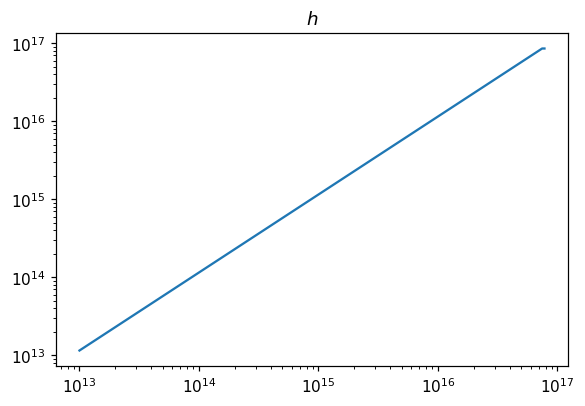

In [14]:
plt.figure(dpi=110)
plt.title(r'$h$')
plt.plot(np.linalg.norm(xs_blk, axis=1), hs)
plt.xscale('log')
plt.yscale('log')

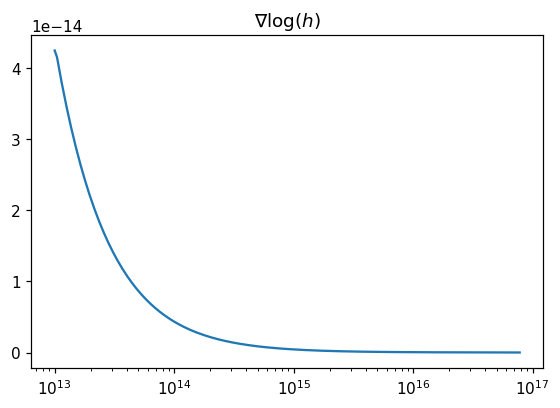

In [15]:
plt.figure(dpi=110)
plt.title(r'$\nabla \log (h)$')
plt.plot(np.linalg.norm(xs_blk, axis=1), dlog_hs)
plt.xscale('log')
# plt.yscale('log')

In [16]:
np.sign(-56)

-1

In [17]:
def RBF_Lucy(r):
    """
    Lucy's smoothing kernel (Lucy 1977).
    """
    # Ensure to take the absolute value
    rr = np.abs(r)
    # Compute Lucy's kernel
    if (rr < 1.0):
        return (1.0 + 3.0*rr) * (1 - rr)**3
    else:
        return 0.0
    
@njit
def grad_RBF_Lucy(r):
    # Ensure to take the absolute value
    rr = np.abs(r)
    # Compute the gradient of Lucy's kernel
    if (rr < 1.0):
        return -12.0 * (rr - 1.0)**2 * rr * np.sign(r)
    else:
        return 0.0

@njit
def grad2_RBF_Lucy(r):
    # Ensure to take the absolute value
    rr = np.abs(r)
    # Compute the gradient^2 of Lucy's kernel
    if (rr < 1.0):
        return -12.0 * (rr - 1.0) * (3.0 * rr - 1.0)
    else:
        return 0.0

In [18]:
@njit
def RBF_hexp(r):
    """
    Minus half exponential kernel.
    """
    # Ensure to take the absolute value
    rr = np.abs(r)
    # Compute hexp kernel
    return np.exp(-0.5*rr)

@njit
def grad_RBF_hexp(r):
    return -0.50 * RBF_hexp(r)

@njit
def grad2_RBF_hexp(r):
    return +0.25 * RBF_hexp(r)

Consider a kernel, $k$, of the form
\begin{equation}
k(x,y) \ = \ K \left( \frac{\|x - y\|^2}{h(x) \, h(y)} \right).
\end{equation}
Then one can compute

\begin{equation}
\partial_{x}k(x,y) \ = \ \frac{1}{h(x) \, h(y)} \Big(+2\left(x-y\right) \ - \ \left(x-y\right)^{2} \ \partial_{x} \log h(x)\Big) K' \left( \frac{\|x - y\|^2}{h(x) \, h(y)} \right)
\end{equation}

\begin{equation}
\partial_{y}k(x,y) \ = \ \frac{1}{h(x) \, h(y)} \Big(-2\left(x-y\right) \ - \ \left(x-y\right)^{2} \ \partial_{y} \log h(y)\Big) K' \left( \frac{\|x - y\|^2}{h(x) \, h(y)} \right)
\end{equation}

\begin{equation}
\begin{split}
\partial_{x}\partial_{y}k(x,y) \ = \
\frac{1}{h(x)^{2} h(y)^{2}}
&\Big(+2\left(x-y\right) \ - \ \left(x-y\right)^{2} \ \partial_{x} \log h(x)\Big) \\
&\Big(-2\left(x-y\right) \ - \ \left(x-y\right)^{2} \ \partial_{y} \log h(y)\Big) \ K'' \left( \frac{\|x - y\|^2}{h(x) \, h(y)} \right) \\
& \hskip-23mm + \frac{1}{h(x) \, h(y)}
\Big(-2 \ + \ 2 \left(x-y\right)     \ \partial_{x} \log h(x)
        \ - \ 2 \left(x-y\right)     \ \partial_{y} \log h(y)
        \ + \   \left(x-y\right)^{2} \ \partial_{x} \log h(x) \ \partial_{y} \log h(y) \Big) K' \left( \frac{\|x - y\|^2}{h(x) \, h(y)} \right)
\end{split}
\end{equation}

In [19]:
# Define kernel
KK       = RBF_hexp
grad_KK  = grad_RBF_hexp
grad2_KK = grad2_RBF_hexp

In [20]:
# Define kernel
KK       = RBF_Lucy
grad_KK  = grad_RBF_Lucy
grad2_KK = grad2_RBF_Lucy

In [21]:
# @njit
def kernel(i1, i2):
    """
    k(x1,x2) = K(|x1-x2|^2 / h(x1)h(x2))
    """
    d = xs[i1] - xs[i2]
    r = np.dot(d,d) / (hs[i1] * hs[i2])
    return KK(r)

# @njit
def d1_kernel(i1, i2):
    """
    ∂k(x1,x2)/∂x1
    """
    d = xs[i1] - xs[i2]
    a = 1.0 / (hs[i1] * hs[i2])
    r = np.dot(d,d) * a
    return (+2.0*d*a - r*dlog_hs[i1]) * grad_KK(r)

# @njit
def d2_kernel(i1, i2):
    """
    ∂k(x1,x2)/∂x2
    """
    d = xs[i1] - xs[i2]
    a = 1.0 / (hs[i1] * hs[i2])
    r = np.dot(d,d) * a
    return (-2.0*d*a - r*dlog_hs[i2]) * grad_KK(r)

# @njit
def d1d2_kernel(i1, i2):
    """
    ∂∂k(x1,x2)/∂x1∂x2
    """
    d = xs[i1] - xs[i2]
    a = 1.0 / (hs[i1] * hs[i2])
    r = np.dot(d,d) * a
    term1 = - 2.0 * a * (1.0 + d*(dlog_hs[i2] - dlog_hs[i1])) \
            + r * dlog_hs[i1] * dlog_hs[i2] 
    term2 =  (+2.0*d*a - r*dlog_hs[i1]) \
            *(-2.0*d*a - r*dlog_hs[i2])
    return term1*grad_KK(r) + term2*grad2_KK(r)

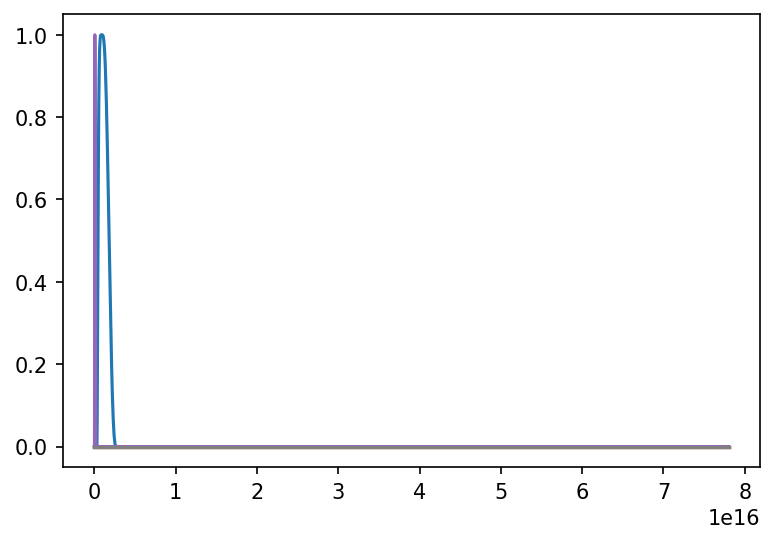

In [22]:
plt.figure(dpi=150)

ks      = [     kernel(npoints//2, i) for i in range(npoints)]
d1_ks   = [  d1_kernel(npoints//2, i) for i in range(npoints)]
d2_ks   = [  d2_kernel(npoints//2, i) for i in range(npoints)]
d1d2_ks = [d1d2_kernel(npoints//2, i) for i in range(npoints)]

plt.plot(xs,      ks)
plt.plot(xs,   d1_ks)
plt.plot(xs,   d2_ks)
plt.plot(xs, d1d2_ks)

ks      = [     kernel(40, i) for i in range(npoints)]
d1_ks   = [  d1_kernel(40, i) for i in range(npoints)]
d2_ks   = [  d2_kernel(40, i) for i in range(npoints)]
d1d2_ks = [d1d2_kernel(40, i) for i in range(npoints)]

plt.plot(xs,      ks)
plt.plot(xs,   d1_ks)
plt.plot(xs,   d2_ks)
plt.plot(xs, d1d2_ks)

# plt.xscale('log')
# plt.yscale('log')

In [23]:
# Specify dimensions of (sub-spaces of) the domain
xdim_blk = [npoints,   nfreqs, nrays]
xdim_bdy = [nboundary, nfreqs, nrays]
# Specify dimensions of (sub-spaces of) the codomain
ydim_blk = [1]
ydim_bdy = [1]
# Get total dims
dims_blk = xdim_blk + ydim_blk
dims_bdy = xdim_bdy + ydim_bdy
# Initialize indices and reductions
inds_blk = [np.arange(dim) for dim in dims_blk]
inds_bdy = [np.arange(dim) for dim in dims_bdy]
# (Optionally) specify reductions of sub-spaces
# Set default for reductions
REDS_blk = [np.arange(dim) for dim in dims_blk]
def reds_blk(ii):
    REDS_blk[0] = red_blk[ii[0]]
    return REDS_blk
REDS_bdy = [np.arange(dim) for dim in dims_bdy]
def reds_bdy(ii):
    REDS_bdy[0] = red_bdy[ii[0]]
    return REDS_bdy
# Get dimensions of linearised spaces
dim_blk = np.prod(dims_blk)
dim_bdy = np.prod(dims_bdy)
dim_tot = dim_blk + dim_bdy
# Get indices of linearised spaces
linds_blk = np.arange(dim_blk).reshape(dims_blk)
linds_bdy = np.arange(dim_bdy).reshape(dims_bdy)

def bdy_2_blk(ii):
    ii = list(ii)
    ii[0] = boundary2point[ii[0]]
    return tuple(ii)

In [24]:
def get_datsize_S22():

    # Set index
    index = 0

    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        ii1     = linds_bdy[ii1_bdy]
        for ii2_bdy in itertools.product(*reds_bdy(ii1_bdy)):    
            ii2_blk = bdy_2_blk(ii2_bdy)
            ii2     = linds_bdy[ii2_bdy]
            if (ii1 <= ii2):
                index += 1
                if (ii1 < ii2):
                    index += 1

    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)): 
            index += 2
            
    for ii1_blk in itertools.product(*inds_blk):
        ii1 = linds_blk[ii1_blk] + dim_bdy
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk] + dim_bdy
            if (ii1 <= ii2):
                index += 1
                if (ii1 < ii2):
                    index += 1
                    
    return index+1


def get_datsize_S12():

    # Set index
    index = 0
    
    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        ii1     = linds_bdy[ii1_bdy]
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk]
            index += 1

    for ii1_blk in itertools.product(*inds_blk):
        ii1 = linds_blk[ii1_blk]
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk] + dim_bdy
            index += 1
                    
    return index+1

In [25]:
datsize_S22 = get_datsize_S22()
datsize_S12 = get_datsize_S12()

print('S12 size:', datsize_S12)
print('S22 size:', datsize_S22)

S12 size: 161601
S22 size: 163217


In [26]:
# @njit
def k (ii1, ii2):
    # Unpack indices
    p1, p2 = ii1[0], ii2[0]
    f1, f2 = ii1[1], ii2[1]
    r1, r2 = ii1[2], ii2[2]
    z1, z2 = ii1[3], ii2[3]
    # Apply operator
    return kernel(p1, p2)

# @njit
def B2_k(ii1, ii2):
    """
    B2 k(x1,x2) = k(x1,x2)
    """
    return k(ii1, ii2)

# @njit
def L2_k(ii1, ii2):
    """
    L2 k(x1,x2) = (1 + ∇2/χ2) k(x1,x2)
    """
    # Unpack indices
    p1, p2 = ii1[0], ii2[0]
    f1, f2 = ii1[1], ii2[1]
    r1, r2 = ii1[2], ii2[2]
    z1, z2 = ii1[3], ii2[3]
    # Apply operator
    return kernel(p1,p2) + d2_kernel(p1,p2) / chi[p2,f2]

# @njit
def B1B2_k(ii1, ii2):
    """
    B1 B2 k(x1,x2) = k(x1,x2)
    """
    return k(ii1, ii2)

# @njit
def B1L2_k(ii1, ii2):
    """
    B1L2 k(x1,x2) = L2 k(x1,x2)
    """
    return L2_k(ii1,ii2)

# @njit
def L1L2_k(ii1, ii2):
    """
    L1 L2 k(x1,x2) = (1 + ∇1/χ1) (1 + ∇2/χ2) k(x1,x2)
    """
    # Unpack indices
    p1, p2 = ii1[0], ii2[0]
    f1, f2 = ii1[1], ii2[1]
    r1, r2 = ii1[2], ii2[2]
    z1, z2 = ii1[3], ii2[3]
    # Apply operator
    return         kernel(p1,p2)              \
            +   d2_kernel(p1,p2) / chi[p2,f2] \
            +   d1_kernel(p1,p2) / chi[p1,f1] \
            + d1d2_kernel(p1,p2) / chi[p1,f1] / chi[p2,f2]

# @njit
def get_boundary_condition(ii1):
    # Unpack indices
    p1 = ii1[0]
    f1 = ii1[1]
    r1 = ii1[2]
    z1 = ii1[3]
    return boundary_condition[p1,f1]

# @njit
def get_operator_condition(ii1):
    # Unpack indices
    p1 = ii1[0]
    f1 = ii1[1]
    r1 = ii1[2]
    z1 = ii1[3]
    return operator_condition[p1,f1]

In [27]:
# # @njit
# def B1_k(ii1, ii2):
#     """
#     B1 k(x1,x2) = (1 + ∇1/χ1) k(x1,x2)
#     """
#     # Unpack indices
#     p1, p2 = ii1[0], ii2[0]
#     f1, f2 = ii1[1], ii2[1]
#     r1, r2 = ii1[2], ii2[2]
#     z1, z2 = ii1[3], ii2[3]
#     # Apply operator
#     if (np.dot(boundary_normal[point2boundary[p1]], Rs[r1]) < 0.0):
#         if (z2 == 0):
#             return +kernel(p1,p2)
#         else:
#             return +kernel(p1,p2)
#     else:
#         if (z2 == 0):
#             return +kernel(p1,p2)
#         else:
#             return -kernel(p1,p2)
        
# # @njit
# def L1_k(ii1, ii2):
#     """
#     L1 k(x1,x2) = (1 + ∇1/χ1) k(x1,x2)
#     """
#     # Unpack indices
#     p1, p2 = ii1[0], ii2[0]
#     f1, f2 = ii1[1], ii2[1]
#     r1, r2 = ii1[2], ii2[2]
#     z1, z2 = ii1[3], ii2[3]
#     # Apply operator
#     if (z1 == 0):
#         if (z2 == 0):
#             return d1_kernel(p1,p2)
#         else:
#             return kernel(p1,p2)
#     else:
#         if (z2 == 0):
#             return kernel(p1,p2)
#         else:
#             return d1_kernel(p1,p2)


# # @njit
# def B1B2_k(ii1, ii2):
#     """
#     B1 B2 k(x1,x2) = (1 + ∇1/χ1) k(x1,x2)
#     """
#     # Unpack indices
#     p1, p2 = ii1[0], ii2[0]
#     f1, f2 = ii1[1], ii2[1]
#     r1, r2 = ii1[2], ii2[2]
#     z1, z2 = ii1[3], ii2[3]
#     # Apply operator
#     if (np.dot(boundary_normal[point2boundary[p1]], Rs[r1]) < 0.0):
#         if (z2 == 0):
#             return 2.0 * kernel(p1,p2)
#         else:
#             return 0.0
#     else:
#         if (z2 == 0):
#             return 0.0
#         else:
#             return 2.0 * kernel(p1,p2)

# # @njit
# def L1B2_k(ii1, ii2):
#     """
#     L1 B2 k(x1,x2) = (1 + ∇1/χ1) k(x1,x2)
#     """
#     # Unpack indices
#     p1, p2 = ii1[0], ii2[0]
#     f1, f2 = ii1[1], ii2[1]
#     r1, r2 = ii1[2], ii2[2]
#     z1, z2 = ii1[3], ii2[3]
#     # Apply operator
#     if (np.dot(boundary_normal[point2boundary[p1]], Rs[r1]) < 0.0):
#         if (z2 == 0):
#             return +kernel(p1,p2) + d1_kernel(p1,p2) / chi[p1,f1]
#         else:
#             return +kernel(p1,p2) + d1_kernel(p1,p2) / chi[p1,f1]
#     else:
#         if (z2 == 0):
#             return -kernel(p1,p2) + d1_kernel(p1,p2) / chi[p1,f1]
#         else:
#             return +kernel(p1,p2) - d1_kernel(p1,p2) / chi[p1,f1]
            

# # @njit
# def L1L2_k(ii1, ii2):
#     """
#     L1 L2 k(x1,x2) = [ 1 + (∇1/χ1) (∇2/χ2)  (∇1/χ1)  +  (∇2/χ2) ] 
#                      [ (∇1/χ1)  +  (∇2/χ2)  1 + (∇1/χ1) (∇2/χ2) ] k(x1,x2)
#     """
#     # Unpack indices
#     p1, p2 = ii1[0], ii2[0]
#     f1, f2 = ii1[1], ii2[1]
#     r1, r2 = ii1[2], ii2[2]
#     z1, z2 = ii1[3], ii2[3]
#     # Apply operator
#     if (z1 == z2):
#         return kernel(p1,p2) + d1d2_kernel(p1,p2) / (chi[p1,f1] * chi[p2,f2])
#     else:
#         return d2_kernel(p1,p2) / chi[p2,f2] + d1_kernel(p1,p2) / chi[p1,f1]

\begin{equation}
\left[
\begin{array}{rr}
             f(x_{\texttt{i}}) \\
    \text{B} f(x_{\texttt{b}}) \\
    \text{L} f(x_{\texttt{a}})
\end{array} 
\right]\
\ \sim \
\mathcal{N}
\left(
    \left[
    \begin{array}{rr}
                 \mu(x_{\texttt{i}}) \\
        \text{B} \mu(x_{\texttt{b}}) \\
        \text{L} \mu(x_{\texttt{a}})
    \end{array}
    \right],
    \left[
    \begin{array}{rrr}
                   k(x_{\texttt{i}}, x_{\texttt{i}}) &                \text{B}^{(2)} k(x_{\texttt{i}}, x_{\texttt{b}}) &                \text{L}^{(2)} k(x_{\texttt{i}}, x_{\texttt{a}}) \\
    \text{B}^{(1)} k(x_{\texttt{b}}, x_{\texttt{i}}) & \text{B}^{(1)} \text{B}^{(2)} k(x_{\texttt{b}}, x_{\texttt{b}}) & \text{B}^{(1)} \text{L}^{(2)} k(x_{\texttt{b}}, x_{\texttt{a}}) \\
    \text{L}^{(1)} k(x_{\texttt{a}}, x_{\texttt{i}}) & \text{L}^{(1)} \text{B}^{(2)} k(x_{\texttt{a}}, x_{\texttt{b}}) & \text{L}^{(1)} \text{L}^{(2)} k(x_{\texttt{a}}, x_{\texttt{a}})
    \end{array}
    \right]
\right) .
\end{equation}

In [28]:
# @njit
def get_Sigma12():
    """
    Σ12 = [ B(2) k(xi,xb)  L(2) k(xi,xa) ]
    """
    # initialize
    data = np.zeros(datsize_S12, dtype=np.float64)
    id_1 = np.zeros(datsize_S12, dtype=np.int64)
    id_2 = np.zeros(datsize_S12, dtype=np.int64)
    # set index
    index = 0
    
    for ii2_bdy in itertools.product(*inds_bdy):
        ii2_blk = bdy_2_blk(ii2_bdy)
        ii2     = linds_bdy[ii2_bdy]
        for ii1_blk in itertools.product(*reds_blk(ii2_blk)):
            ii1 = linds_blk[ii1_blk]
            # Compute element
            Bk = B2_k(ii1_blk, ii2_blk)
            # Add element
            data[index] = Bk
            id_1[index] = ii1
            id_2[index] = ii2
            index += 1

    for ii1_blk in itertools.product(*inds_blk):
        ii1 = linds_blk[ii1_blk]
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk] + dim_bdy
            # Compute element
            Lk = L2_k(ii1_blk, ii2_blk)
            # Add element
            data[index] = Lk
            id_1[index] = ii1
            id_2[index] = ii2
            index += 1

    return (data, (id_1, id_2))


def get_Sigma22():
    """
    Σ22 = [ B(1) k(xb,xb) B(2)  B(1) k(xb,xa) L(2) ]
          [ L(1) k(xa,xb) B(2)  L(1) k(xa,xa) L(2) ]
    """
    # Initialize
    data = np.zeros(datsize_S22, dtype=np.float64)
    id_1 = np.zeros(datsize_S22, dtype=np.int64)
    id_2 = np.zeros(datsize_S22, dtype=np.int64)
    # Set index
    index = 0

    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        ii1     = linds_bdy[ii1_bdy]
        for ii2_bdy in itertools.product(*reds_bdy(ii1_bdy)):    
            ii2_blk = bdy_2_blk(ii2_bdy)
            ii2     = linds_bdy[ii2_bdy]
            if (ii1 <= ii2):
                # Compute element
                BB = B1B2_k(ii1_blk, ii2_blk)
                # Add upper triangular part
                data[index] = BB
                id_1[index] = ii1
                id_2[index] = ii2
                index += 1
                if (ii1 < ii2):
                    # Add lower triangular part
                    data[index] = BB
                    id_1[index] = ii2
                    id_2[index] = ii1
                    index += 1

    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        ii1     = linds_bdy[ii1_bdy]
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk] + dim_bdy   
            # Compute element
            LB = B1L2_k(ii1_blk, ii2_blk)
            # Add upper triangular part
            data[index] = LB
            id_1[index] = ii1
            id_2[index] = ii2
            index += 1
            # Add lower triangular part
            data[index] = LB
            id_1[index] = ii2
            id_2[index] = ii1 
            index += 1
            
    for ii1_blk in itertools.product(*inds_blk):
        ii1 = linds_blk[ii1_blk] + dim_bdy
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk] + dim_bdy
            if (ii1 <= ii2):
                # Compute element
                LL = L1L2_k(ii1_blk, ii2_blk)
                # Add upper triangular part
                data[index] = LL
                id_1[index] = ii1
                id_2[index] = ii2
                index += 1
                if (ii1 < ii2):
                    # Add lower triangular part
                    data[index] = LL
                    id_1[index] = ii2
                    id_2[index] = ii1
                    index += 1
                    
    # Return the data
    return (data, (id_1, id_2))


# @njit
def get_condition():
    """
    condition = [ boundary condition ]
                [ operator condition ] 
    """
    # initialize
    condition = np.zeros(dim_tot)

    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        ii1     = linds_bdy[ii1_bdy]
        # Set boundary condition
        condition[ii1] = get_boundary_condition(ii1_bdy)
        
    for ii1_blk in itertools.product(*inds_blk):
        ii1 = linds_blk[ii1_blk] + dim_bdy
        # Set operator condition
        condition[ii1] = get_operator_condition(ii1_blk)

    return condition

In [29]:
SIGMA22 = get_Sigma22() 
Sigma22 = sparse.coo_matrix(SIGMA22, shape=(dim_tot, dim_tot)).tocsc()
S22     = Sigma22.todense()

In [47]:
np.min(S22)

-1597983.741722515

In [48]:
np.max(S22)

1417151.0753360484

In [30]:
P     = np.sqrt(np.diag(np.diag(S22)))
P_inv = np.linalg.inv(P)

In [31]:
P*P_inv

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [32]:
np.linalg.cond(S22)

3.7353111951317846e+52

In [33]:
np.linalg.cond(P_inv * S22 * P_inv)

3.7353111951317846e+52

In [46]:
np.linalg.det(S22)

0.0

In [35]:
np.linalg.det(P_inv * S22 * P_inv)

0.0

In [36]:
print(Sigma22.todense())

[[1.00000000e+00 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 ... 1.80074940e+00
  1.00000000e+00 1.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 1.80074940e+00 ... 1.00000000e+00
  3.41841921e+04 3.41841921e+04]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 ... 3.41841921e+04
  1.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 ... 3.41841921e+04
  1.00000000e+00 1.00000000e+00]]


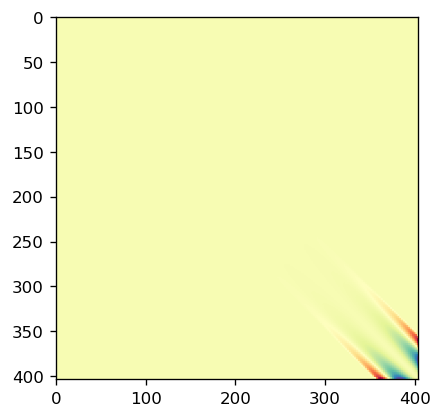

In [37]:
vmin = -np.max(np.abs(Sigma22.todense()))
vmax = +np.max(np.abs(Sigma22.todense()))
plt.figure(dpi=120)
plt.imshow(Sigma22.todense(), cmap='Spectral')
# plt.scatter(SIGMA22[1][1], SIGMA22[1][0], c='k', marker='.', s=1)

In [38]:
SIGMA12 = get_Sigma12()
Sigma12 = sparse.coo_matrix(SIGMA12, shape=(dim_blk, dim_tot)).tocsc()

In [39]:
print(Sigma12.todense())

[[1.         1.         0.         ... 0.         0.         0.        ]
 [1.         1.         0.         ... 0.         0.         0.        ]
 [0.99998599 0.99998599 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.99998467 ... 1.         0.12810704 0.12810704]
 [0.         0.         1.         ... 1.8007494  1.         1.        ]
 [0.         0.         1.         ... 1.8007494  1.         1.        ]]


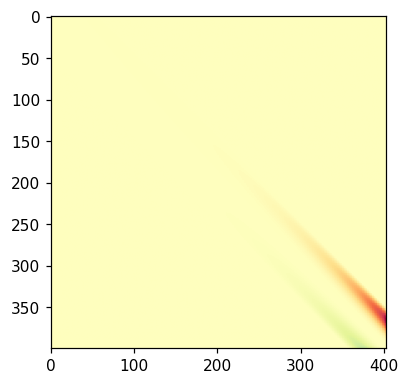

In [40]:
vmin = -np.max(np.abs(Sigma12.todense()))
vmax = +np.max(np.abs(Sigma12.todense()))
plt.figure(dpi=110)
plt.imshow(Sigma12.todense(), cmap='Spectral', vmin=vmin, vmax=vmax)
# plt.scatter(SIGMA12[1][1], SIGMA12[1][0], c='k', marker='X', s=2)

In [41]:
condition = get_condition()
condition

array([3.77281369e-18, 3.77281369e-18, 3.77281369e-18, 3.77281369e-18,
       1.58983312e-16, 1.58983312e-16, 1.58983312e-16, 1.58983312e-16,
       1.58983312e-16, 1.58983312e-16, 1.58983312e-16, 1.58983312e-16,
       1.58983312e-16, 1.58983312e-16, 1.58983312e-16, 1.58983312e-16,
       1.58983312e-16, 1.58983312e-16, 1.58983312e-16, 1.58983312e-16,
       1.58983312e-16, 1.58983312e-16, 1.58983312e-16, 1.58983312e-16,
       1.58983312e-16, 1.58983312e-16, 1.58983312e-16, 1.58983312e-16,
       1.58983312e-16, 1.58983312e-16, 1.58983312e-16, 1.58983312e-16,
       1.58983312e-16, 1.58983312e-16, 1.58983312e-16, 1.58983312e-16,
       1.58983312e-16, 1.58983312e-16, 1.58983312e-16, 1.58983312e-16,
       1.58983312e-16, 1.58983312e-16, 1.58983312e-16, 1.58983312e-16,
       1.58983312e-16, 1.58983312e-16, 1.58983312e-16, 1.58983312e-16,
       1.58983312e-16, 1.58983312e-16, 1.58983312e-16, 1.58983312e-16,
       1.58983312e-16, 1.58983312e-16, 1.58983312e-16, 1.58983312e-16,
      

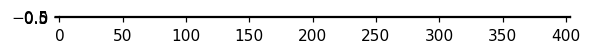

In [42]:
plt.figure(dpi=110)
plt.imshow([condition], cmap='Spectral')

In [43]:
from scipy.sparse.linalg import minres
from scipy.sparse.linalg import lobpcg

In [44]:
x, exitCode = lobpcg(Sigma22, condition)

ValueError: expected rank-2 array for argument X

In [45]:
exitCode

NameError: name 'exitCode' is not defined

In [79]:
Sigma12.dot(x)

array([ 9.97597980e+00,  3.51727460e+00,  1.31243388e+00,  4.65211488e-01,
        1.17089509e-01,  1.13392809e-01,  4.32776949e-02, -6.35331360e-02,
       -7.78162803e-03,  7.09288884e-02,  7.77494963e-03, -7.18352781e-02,
       -3.46164712e-02,  2.37063160e-02, -4.95092573e-03, -5.71526389e-02,
       -5.03632543e-02, -1.11048953e-02,  1.78437961e-02,  2.38208629e-02,
       -9.70758729e-03, -2.51674985e-02,  4.76695420e-02,  6.14566104e-02,
        3.40992259e-03, -1.23917913e-01, -6.95885407e-02, -2.71493754e-02,
        8.65670420e-03,  8.39929441e-03, -3.59391300e-02, -2.76260949e-03,
        5.96363257e-02,  2.67642293e-02, -3.47544206e-02, -1.12254880e-02,
        3.73695956e-02,  2.00188766e-02, -9.36024760e-03,  1.18211102e-02,
        2.73177067e-02,  8.52413617e-03,  1.90755310e-02,  2.98585867e-02,
       -3.62775352e-02, -4.46999644e-02,  6.37422384e-02, -1.85767430e-02,
       -6.61330575e-03,  1.35904084e-01])

In [74]:
weight = sparse.linalg.spsolve(Sigma22, condition)
result = Sigma12.dot(weight)
result

array([ 1.00000000e+01,  3.57848454e+00,  1.28151922e+00,  4.59446976e-01,
        1.64695286e-01,  5.84036517e-02,  1.94093707e-02,  4.41285302e-03,
       -2.02953885e-03, -5.38834387e-03, -7.55559095e-03, -9.13107758e-03,
       -1.02396176e-02, -1.08231730e-02, -1.07455229e-02, -9.83042412e-03,
       -7.87708008e-03, -4.67018846e-03,  4.55946595e-06,  6.32185233e-03,
        1.43081441e-02,  2.35271017e-02,  3.21600769e-02,  3.43087458e-02,
        1.20721389e-02, -8.77371908e-02, -5.30872295e-02, -3.74517679e-02,
       -2.82260753e-02, -2.12967994e-02, -1.53970682e-02, -1.01911699e-02,
       -5.62783482e-03, -1.72489779e-03,  1.49951211e-03,  4.04619899e-03,
        5.93756487e-03,  7.21499498e-03,  7.93488515e-03,  8.16483520e-03,
        7.98102594e-03,  7.46850443e-03,  6.72881380e-03,  5.90724717e-03,
        5.27403848e-03,  5.45545539e-03,  8.08317849e-03,  1.76124912e-02,
        4.64079934e-02,  1.28965420e-01])

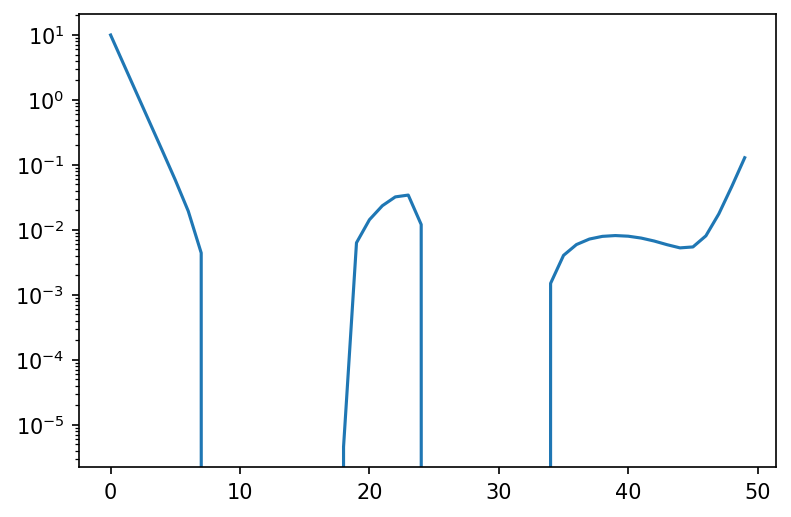

In [75]:
plt.figure(dpi=150)
plt.plot(rs, result)
# plt.xscale('log')
plt.yscale('log')

In [98]:
norm_22         = sparse.linalg.norm(Sigma22)
norm_22_inverse = sparse.linalg.norm(sparse.linalg.inv(Sigma22))

cond = norm_22 * norm_22_inverse
cond

RuntimeError: Factor is exactly singular

In [99]:
Sigma12 * sparse.linalg.inv(Sigma22) * condition

RuntimeError: Factor is exactly singular

In [45]:
51**2

2601